In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from itertools import combinations
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('data/daily_close.csv', index_col=[0])

In [3]:
def get_headge_ratio(ticker1, ticker2, data):
    X = sm.add_constant(data[ticker1])
    y = data[ticker2]
    model = sm.OLS(y, X).fit()
    hedge_ratio = model.params[ticker1]

    return hedge_ratio


def spread(ticker1, ticker2, data, hedge_ratio):
    S2_bought = 100
    S1_bought = int(100*hedge_ratio)
    spread_v = 100*data[ticker2].iloc[-1] - int(100*hedge_ratio)*data[ticker1].iloc[-1]
    return spread_v, -1*S1_bought, S2_bought

def plot_spread(ticker1, ticker2, data, hedge_ratio):
    t_values = range(0, len(data) - int(len(data)*0.7))
    spread_values_list = []
    dates = []

    for t in tqdm.tqdm(t_values):
        spread_values_list.append(spread('APOLLOHOSP','SUNPHARMA', data[:int(len(data)*0.7) + t], hedge_ratio)[0])
        dates.append(data[:int(len(data)*0.7) + t].index[-1])
    
    plt.figure(figsize=(12, 6))
    plt.plot(dates, spread_values_list)
    plt.title(f'Spread between {ticker1} and {ticker2}')
    plt.xlabel('Date')
    plt.ylabel('Spread Value')
    plt.grid(True)
    plt.xticks(rotation=90)
    plt.xticks(dates[::len(dates)//50])
    plt.tight_layout()
    plt.show()

def get_polynomial_slope(spread_values_list, dates, closness):
    degree = min(int(len(dates) / closness) + 1, len(dates)-1)
    x = np.arange(len(dates))
    y = np.array(spread_values_list)
    
    coeffs = np.polyfit(x, y, degree)
    polynomial = np.poly1d(coeffs)
    
    slope = polynomial.deriv()(x[-1])    
    return slope

def make_slope_curve(spread_values_list, dates, closness):
    slopes = []
    for i in range(10, len(spread_values_list)):
        slope = get_polynomial_slope(spread_values_list[0:i], dates[0:i], closness)
        slopes.append(slope)
    plt.figure(figsize=(12, 8))
    plt.plot(dates[10:], slopes)
    plt.xlabel('time')
    plt.ylabel('Slope Value')
    plt.grid(True)
    plt.xticks(rotation=90)
    plt.xticks(dates[::len(dates)//50])
    plt.tight_layout()
    plt.show()

def get_signals(spread_values_list, dates, closness, quantity_S1, quantity_S2):
    slopes = []
    signals = []
    order_book = []
    for i in range(10, len(spread_values_list)):
        slope = get_polynomial_slope(spread_values_list[0:i], dates[0:i], closness)
        if len(slopes) > 0:
            if slopes[-1] > 0 and slope < 0:
                signals.append((dates[i], "buy", spread_values_list[i]))
                order_book.append((dates[i], quantity_S1, quantity_S2))
            if slopes[-1] < 0 and slope > 0:
                signals.append((dates[i], "sell", spread_values_list[i]))
                order_book.append((dates[i], -1*quantity_S1, -1*quantity_S2))
        slopes.append(slope)
    return signals, order_book 

In [4]:
ticker1 = 'COALINDIA'
ticker2 = 'ONGC'

hedge_ratio = get_headge_ratio(ticker1,ticker2, data[:int(len(data)*0.7)])
_, quantity_S1, quantity_S2 = spread(ticker1,ticker2, data[:int(len(data)*0.7)], hedge_ratio)

t_values = range(0, len(data) - int(len(data)*0.7))
spread_values_list = []
dates = []

for t in tqdm.tqdm(t_values):
    spread_values_list.append(spread(ticker1,ticker2, data[:int(len(data)*0.7) + t], hedge_ratio)[0])
    dates.append(data[:int(len(data)*0.7) + t].index[-1])

100%|██████████| 421/421 [00:00<00:00, 12633.99it/s]


In [5]:
signals, order_book = get_signals(spread_values_list, dates, 100, quantity_S1, quantity_S2)

In [6]:
signals

[('2024-01-23 09:15:00', 'sell', 471.9995999999992),
 ('2024-06-20 09:15:00', 'buy', -1803.9984000000004),
 ('2024-08-13 09:15:00', 'sell', 2284.9990000000034),
 ('2024-09-16 09:15:00', 'buy', -345.0),
 ('2024-11-13 09:15:00', 'sell', 841.0),
 ('2025-04-08 09:15:00', 'buy', -305.0)]

In [7]:
def final_metrics(ticker1, ticker2, data, closness, verbos = True):
    hedge_ratio = get_headge_ratio(ticker1,ticker2, data[:int(len(data)*0.7)])
    _, quantity_S1, quantity_S2 = spread(ticker1,ticker2, data[:int(len(data)*0.7)], hedge_ratio)

    rev_hedge_ratio = get_headge_ratio(ticker2,ticker1, data[:int(len(data)*0.7)])
    _, r_quantity_S1, _ = spread(ticker2, ticker1, data[:int(len(data)*0.7)], rev_hedge_ratio)

    if r_quantity_S1 < quantity_S1:
        ticker1, ticker2 = ticker2, ticker1
        hedge_ratio = get_headge_ratio(ticker1,ticker2, data[:int(len(data)*0.7)])
        _, quantity_S1, quantity_S2 = spread(ticker1,ticker2, data[:int(len(data)*0.7)], hedge_ratio)


    t_values = range(0, len(data) - int(len(data)*0.7))
    spread_values_list = []
    dates = []

    for t in tqdm.tqdm(t_values):
        spread_values_list.append(spread(ticker1,ticker2, data[:int(len(data)*0.7) + t], hedge_ratio)[0])
        dates.append(data[:int(len(data)*0.7) + t].index[-1])
    
    if verbos:
        print(f"spread is made up of {quantity_S1}*{ticker1} + {quantity_S2}*{ticker2}")    
    signals, _ = get_signals(spread_values_list, dates, closness, quantity_S1, quantity_S2)

    if verbos:
        plt.figure(figsize=(12, 6))
        plt.plot(dates, spread_values_list)
        
        for date, signal, price in signals:
            if signal == 'buy':
                plt.scatter(date, price, color='green', marker='^', s=100)
            elif signal == 'sell':
                plt.scatter(date, price, color='red', marker='v', s=100)
        
        plt.xlabel('Date')
        plt.ylabel('Spread')
        plt.grid(True)
        plt.xticks(rotation=90)
        plt.xticks(dates[::len(dates)//50])
        plt.tight_layout()
        plt.show()

    total_profit = 0
    for date, signal, price in signals:
        if signal == "sell":
            total_profit += price
        if signal == "buy":
            total_profit -= price
    
    if signals[0][1] == "buy" and signals[-1][1] == "buy":
        total_profit += signals[-1][2]
        if verbos:
            print("haven't counted the last buy trade in final profit calculation to equate number of buys = number of sells")

    if signals[0][1] == "sell" and signals[-1][1] == "sell":
        total_profit -= signals[-1][2]
        if verbos:
            print("haven't counted the last sell trade in final profit calculation to equate number of buys = number of sells")

    if verbos:
        print(f"total profit: {total_profit}")
        for date, signal, price in signals:
            print(f"on {date}, {signal} at {price}")
    
    return total_profit

APOLLOHOSP SUNPHARMA

BAJAJ-AUTO HEROMOTOCO

BPCL ONGC

COALINDIA ONGC

ICICIBANK SBIN

In [36]:
print(final_metrics('APOLLOHOSP', 'SUNPHARMA', data, 27, verbos=False))
print(final_metrics('BAJAJ-AUTO', 'HEROMOTOCO', data, 30, verbos=False))
print(final_metrics('BPCL', 'ONGC', data, 27, verbos=False))
print(final_metrics('COALINDIA', 'ONGC', data, 27, verbos=False))
print(final_metrics('ICICIBANK', 'SBIN', data, 27, verbos=False))

100%|██████████| 421/421 [00:00<00:00, 12903.10it/s]


90296.09000000008


100%|██████████| 421/421 [00:00<00:00, 14821.36it/s]


7109.635599999921


100%|██████████| 421/421 [00:00<00:00, 14691.88it/s]


9521.23561


100%|██████████| 421/421 [00:00<00:00, 14535.86it/s]


10479.243330000012


100%|██████████| 421/421 [00:00<00:00, 2411.08it/s]


15699.50261000004


100%|██████████| 421/421 [00:00<00:00, 2491.21it/s]


spread is made up of -119*SBIN + 100*SBILIFE


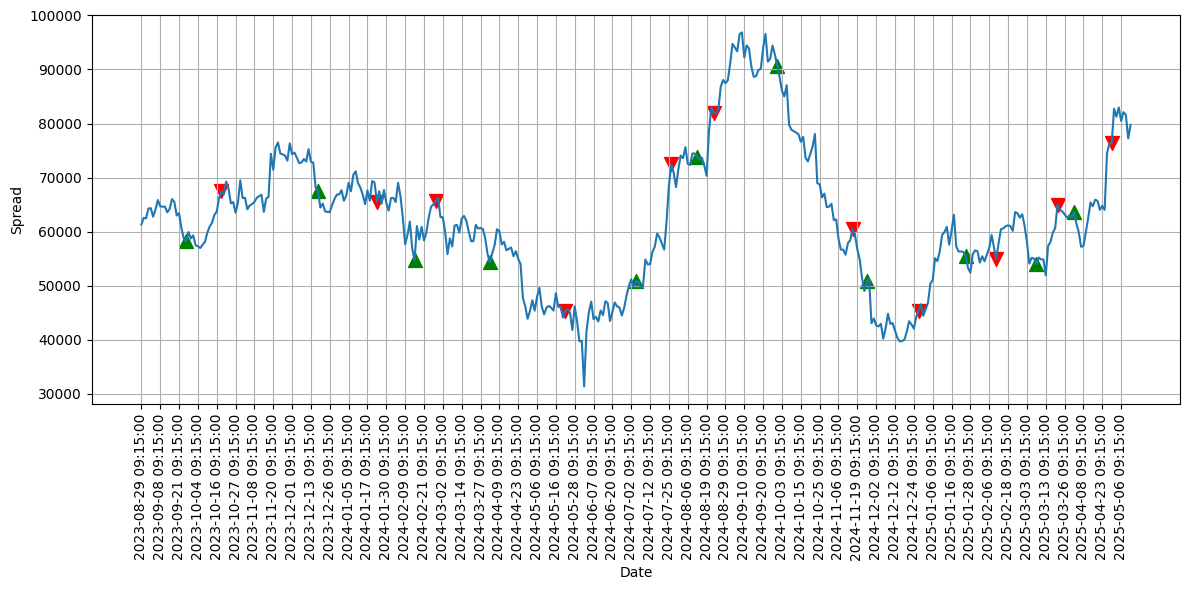

total profit: 26498.79880999998
on 2023-09-26 09:15:00, buy at 58236.39761999999
on 2023-10-18 09:15:00, sell at 67489.64761999999
on 2023-12-18 09:15:00, buy at 67523.5
on 2024-01-23 09:15:00, sell at 65543.10238000001
on 2024-02-15 09:15:00, buy at 54692.69881
on 2024-02-28 09:15:00, sell at 65662.5
on 2024-04-03 09:15:00, buy at 54325.05119
on 2024-05-22 09:15:00, sell at 45308.75
on 2024-07-04 09:15:00, buy at 50898.30119
on 2024-07-26 09:15:00, sell at 72463.44881
on 2024-08-12 09:15:00, buy at 73800.60238000001
on 2024-08-22 09:15:00, sell at 81909.30119
on 2024-09-30 09:15:00, buy at 90639.90000000001
on 2024-11-14 09:15:00, sell at 60524.25
on 2024-11-26 09:15:00, buy at 50786.40000000001
on 2024-12-27 09:15:00, sell at 45371.65000000001
on 2025-01-24 09:15:00, buy at 55486.15000000001
on 2025-02-11 09:15:00, sell at 54899.09999999999
on 2025-03-07 09:15:00, buy at 53962.75
on 2025-03-21 09:15:00, sell at 65009.2
on 2025-04-02 09:15:00, buy at 63646.95
on 2025-04-29 09:15:00, s

26498.79880999998

In [38]:
final_metrics('SBIN', 'SBILIFE', data, 30, verbos=True)

100%|██████████| 421/421 [00:00<00:00, 6247.88it/s]


spread is made up of -156*INFY + 100*TCS


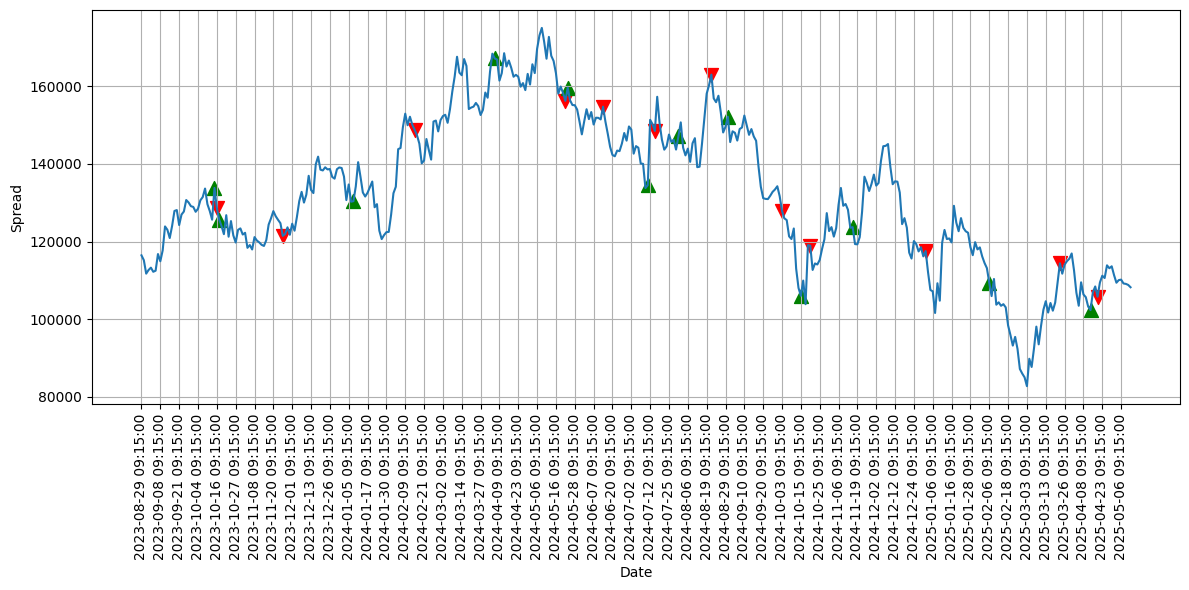

total profit: 14052.830000000133
on 2023-10-13 09:15:00, buy at 133825.61
on 2023-10-16 09:15:00, sell at 128677.59999999998
on 2023-10-17 09:15:00, buy at 125682.79999999999
on 2023-11-24 09:15:00, sell at 121475.60999999999
on 2024-01-09 09:15:00, buy at 130419.19
on 2024-02-15 09:15:00, sell at 148809.42000000004
on 2024-04-05 09:15:00, buy at 167185.40000000002
on 2024-05-22 09:15:00, sell at 156251.2
on 2024-05-23 09:15:00, buy at 159650.59999999998
on 2024-06-13 09:15:00, sell at 154758.78999999998
on 2024-07-11 09:15:00, buy at 134548.8
on 2024-07-16 09:15:00, sell at 148511.02000000002
on 2024-07-31 09:15:00, buy at 147088.00999999995
on 2024-08-21 09:15:00, sell at 163008.8
on 2024-08-30 09:15:00, buy at 152157.8
on 2024-10-03 09:15:00, sell at 127904.59999999998
on 2024-10-15 09:15:00, buy at 106029.20000000001
on 2024-10-21 09:15:00, sell at 118956.0
on 2024-11-14 09:15:00, buy at 123720.19999999995
on 2025-01-01 09:15:00, sell at 117575.0
on 2025-02-06 09:15:00, buy at 1094

14052.830000000133

In [46]:
final_metrics('INFY','TCS', data, 30, verbos=True)